In [ ]:
Context: 

In [4]:
# Code chunk below (genrating HTML data) was obtained from course professor as part of the problem set given

# Import relevant packages for setup
import requests
from bs4 import BeautifulSoup
import re


# Define the debate metadata.
moderators = ["MODERATOR", "SCHIEFFER", "SCHIEFFER", "LEHRER", "HOLT", "WALLACE"]

candidates = [
    {"Dem": "GORE", "Rep": "BUSH"},
    {"Dem": "KERRY", "Rep": "BUSH"},
    {"Dem": "OBAMA", "Rep": "MCCAIN"},
    {"Dem": "OBAMA", "Rep": "ROMNEY"},
    {"Dem": "CLINTON", "Rep": "TRUMP"},
    {"Dem": "BIDEN", "Rep": "TRUMP"}
]

titles = [
    "October 3, 2000: The First Gore-Bush Presidential Debate",
    "October 13, 2004: The Third Bush-Kerry Presidential Debate",
    "October 15, 2008: The Third McCain-Obama Presidential Debate",
    "October 3, 2012: The First Obama-Romney Presidential Debate",
    "September 26, 2016: The First Clinton-Trump Presidential Debate",
    "September 29, 2020: Presidential Debate"
]

years = range(2000, 2024, 4)
url = "https://debates.org/voter-education/debate-transcripts"

# Get the overview HTML page.
response = requests.get(url)
main_html = BeautifulSoup(response.content, 'html.parser')

# Extract the <a> tags with href attributes.
a_nodes = main_html.find_all('a', href=True)
labels = [a_node.get_text() for a_node in a_nodes]

# Find the index of titles in the labels.
selected_indices = [labels.index(title) for title in titles]

# Extract debate URLs using the selected indices.
debate_urls = [a_nodes[i]['href'] for i in selected_indices]

# Fix the URL for 2020 transcript, which is a full URL unlike the others.
debate_urls = [re.sub(r"https://www.debates.org", "", url, count=1) for url in debate_urls]

n = len(debate_urls)

assert all([re.match(r"^/voter-education", url) for url in debate_urls])
assert n == len(years)

# Fetch the HTML content for each debate
debates_html = [BeautifulSoup(requests.get(f"https://debates.org{url}").content, 
                              'html.parser') for url in debate_urls]
assert len(debates_html) == n

def get_content(html):
    # Extracts debate content from html.
    content_node = html.find('div', {'id': 'content-sm'})
    if not content_node:
        raise Exception("No content found!")
    text = content_node.get_text(strip=True)
    
    # Sanity check
    header = content_node.find('h1')
    if header:
        print(header.get_text())
    
    return text

# Get the body content for all debates.
debates_body = [get_content(html) for html in debates_html]
assert len(debates_body) == n

# Visual sanity checks:
print(debates_body[0][:1000])
print(debates_body[5][:1000])

lengths = [len(body) for body in debates_body]
assert min(lengths) > 70000 and max(lengths) < 120000

October 3, 2000 Transcript
October 13, 2004 Debate Transcript
October 15, 2008 Debate Transcript
October 3, 2012 Debate Transcript
September 26, 2016 Debate Transcript
September 29, 2020 Debate Transcript
October 3, 2000 TranscriptOctober 3, 2000The First Gore-Bush Presidential DebateMODERATOR: Good evening from the Clark Athletic Center at the University of Massachusetts in Boston. I’m Jim Lehrer of the NewsHour on PBS, and I welcome you to the first of three 90-minute debates between the Democratic candidate for president, Vice President Al Gore and the Republican candidate, Governor George W. Bush of Texas. The debates are sponsored by the Commission on Presidential Debates and they will be conducted within formats and rules agreed to between the commission and the two campaigns. We’ll have the candidates at podiums. No answer to a question can exceed two minutes. Rebuttal is limited to one minute. But as moderator I have the option to follow up and to extend any particular give and

In [5]:
# Process each debate using the respective candidates and moderator for that debate
def process_debate_transcript(text, moderator, dem_candidate, rep_candidate):
    # Define the speakers
    speakers = [moderator, dem_candidate, rep_candidate]

    # Create a dictionary to hold chunks per speaker
    speaker_chunks = {}

    # Regex pattern to capture speaker's name followed by their text
    # The candidates and moderator names are dynamically placed in the regex pattern
    pattern = re.compile(rf'({"|".join(speakers)}):\s*(.+?)(?={"|".join(speakers)}:|$)', re.DOTALL)

    # Remove non-spoken text like [Laughter], [Applause], etc.
    clean_text = re.sub(r'\[.*?\]', '', text)

    # Find all speaker and text pairs
    matches = pattern.findall(clean_text)

    # Variable to keep track of the last speaker
    last_speaker = None

    for match in matches:
        speaker, speech = match
        speaker = speaker.strip()
        speech = speech.strip()

        # If the speaker doesn't exist in the dictionary, initialize an empty list
        if speaker not in speaker_chunks:
            speaker_chunks[speaker] = []

        # If the same speaker as last time, append to their last chunk
        if last_speaker == speaker:
            speaker_chunks[speaker][-1] += " " + speech
        else:
            speaker_chunks[speaker].append(speech)
            last_speaker = speaker

    # Print the number of chunks per speaker
    for speaker, chunks in speaker_chunks.items():
        print(f"{speaker}: {len(chunks)} chunks")

    return speaker_chunks

# Process each debate
chunks = {}
for i, body in enumerate(debates_body):
    print(f"\nProcessing debate for {years[i]}: {titles[i]}")
    dem_candidate = candidates[i]['Dem']
    rep_candidate = candidates[i]['Rep']
    moderator = moderators[i]
    
    # Process the debate transcript
    chunk = process_debate_transcript(body, moderator, dem_candidate, 
                                      rep_candidate)
    chunks.update(chunk)


Processing debate for 2000: October 3, 2000: The First Gore-Bush Presidential Debate
MODERATOR: 60 chunks
GORE: 49 chunks
BUSH: 56 chunks

Processing debate for 2004: October 13, 2004: The Third Bush-Kerry Presidential Debate
SCHIEFFER: 57 chunks
KERRY: 31 chunks
BUSH: 29 chunks

Processing debate for 2008: October 15, 2008: The Third McCain-Obama Presidential Debate
SCHIEFFER: 55 chunks
MCCAIN: 60 chunks
OBAMA: 45 chunks

Processing debate for 2012: October 3, 2012: The First Obama-Romney Presidential Debate
LEHRER: 76 chunks
OBAMA: 42 chunks
ROMNEY: 54 chunks

Processing debate for 2016: September 26, 2016: The First Clinton-Trump Presidential Debate
HOLT: 97 chunks
CLINTON: 87 chunks
TRUMP: 123 chunks

Processing debate for 2020: September 29, 2020: Presidential Debate
WALLACE: 244 chunks
BIDEN: 266 chunks
TRUMP: 336 chunks


In [20]:
import nltk
from nltk.tokenize import word_tokenize

# Download the necessary tokenizer, if unavailable
# nltk.download('punkt')

# Create a new dictionary to store tokenized results
tokenized_dict = {}

# Iterate over the dictionary and tokenize each value (sentence)
for key, sentences in chunks.items():
    # Tokenize each sentence in the list
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]  
    tokenized_dict[key] = tokenized_sentences

# OPTIONAL - Display the tokenized dictionary
# print(tokenized_dict['OBAMA']);

In [28]:
import pandas as pd
from functools import reduce

# Function to initialize the results dictionary for candidates and moderators
def initialize_results(candidates, moderators):
    return {
        candidate: {"words": 0, "characters": 0, "sentences": 0}
        for candidate in candidates + [moderators]
    }

# Function to calculate sentence statistics for each participant
def calculate_sentence_stats(tokenized_sentences):
    words = sum(len(sentence) for sentence in tokenized_sentences)
    characters = sum(len(word) for sentence in tokenized_sentences for word in 
                     sentence)
    sentences = len(tokenized_sentences)
    return {"words": words, "characters": characters, "sentences": sentences}

# Function to update the results dictionary based on tokenized debate
def update_results(participants, tokenized_dict):
    return {
        participant: calculate_sentence_stats(tokenized_dict.get(participant, []))
        for participant in participants
    }

# Function to merge participant stats with the initialized results
def merge_results(init_results, updated_results):
    return {
        participant: {
            "words": init_results[participant]["words"] + 
            updated_results[participant]["words"],
            "characters": init_results[participant]["characters"] + 
            updated_results[participant]["characters"],
            "sentences": init_results[participant]["sentences"] + 
            updated_results[participant]["sentences"]
        }
        for participant in init_results
    }

# Function to compute the average word length per speaker/candidate
def compute_average_word_length(stats):
    characters, words = stats["characters"], stats["words"]
    return characters / words if words > 0 else 0

# Function to create a DataFrame of stats for each participant
def create_dataframe(participant_stats, debate_year):
    data = []
    for participant, stats in participant_stats.items():
        avg_word_len = compute_average_word_length(stats)
        data.append({
            "Participant": participant,
            "Debate Year": debate_year,
            "Words": stats['words'],
            "Characters": stats['characters'],
            "Sentences": stats['sentences'],
            "Avg Word Length": avg_word_len
        })
    return pd.DataFrame(data)

# Main functional pipeline to collect data into a DataFrame
def process_debates_to_df(candidates, moderators, tokenized_dict, debate_years):
    all_dataframes = []
    
    # Process each debate cycle
    for i in range(len(candidates)):
        # print(f"\n===== Debate Year {debate_years[i]} =====")
        participants = [candidates[i]['Dem'], candidates[i]['Rep'], moderators[i]]
        
        # Initialize results for all participants
        init_results = initialize_results([candidates[i]['Dem'], candidates[i]['Rep']], 
                                          moderators[i])

        # Update results with tokenized data
        updated_results = update_results(participants, tokenized_dict)

        # Merge the initialized and updated results
        final_results = merge_results(init_results, updated_results)

        # Create a DataFrame for this debate year
        df = create_dataframe(final_results, debate_years[i])
        all_dataframes.append(df)
    
    # Combine all DataFrames into one
    final_df = pd.concat(all_dataframes, ignore_index=True)
    return final_df


df = process_debates_to_df(candidates, moderators, tokenized_dict, years)

# Display the DataFrame
print(df)

   Participant  Debate Year  Words  Characters  Sentences  Avg Word Length
0         GORE         2000   8328       32296         49         3.878002
1         BUSH         2000   6698       26358         29         3.935205
2    MODERATOR         2000   2001        8045         60         4.020490
3        KERRY         2004   8567       32654         31         3.811603
4         BUSH         2004   6698       26358         29         3.935205
5    SCHIEFFER         2004   1544        5920         55         3.834197
6        OBAMA         2008   8671       33594         42         3.874294
7       MCCAIN         2008   7716       30054         60         3.895023
8    SCHIEFFER         2008   1544        5920         55         3.834197
9        OBAMA         2012   8671       33594         42         3.874294
10      ROMNEY         2012   9479       35209         54         3.714421
11      LEHRER         2012   1953        7238         76         3.706093
12     CLINTON         20

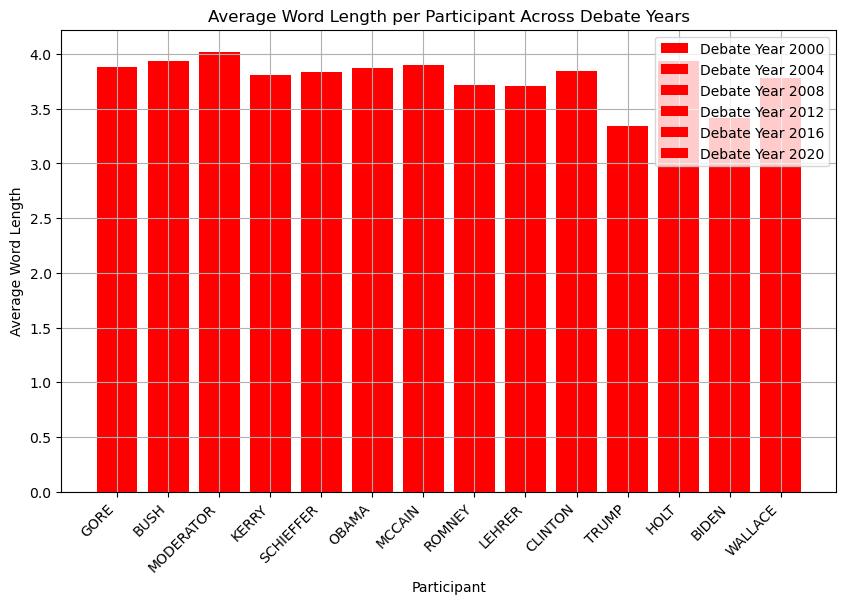

In [32]:
# Visualize output with Matplotlib

import pandas as pd
import matplotlib.pyplot as plt

def plot_avg_word_length(df):
    # Rename the columns for easier reference
    df.columns = ['Participant', 'Debate Year', 'Words', 'Characters', 'Sentences', 'Average WL']
    
    # Identify participants' party affiliation (for color coding)
    party_colors = df['Participant'].apply(lambda x: 'blue' if 'Dem' in x else 'red')
    
    # Group data by Debate Year and Participant
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create a bar plot with different colors for Democrats and Republicans
    for year in df['Debate Year'].unique():
        year_data = df[df['Debate Year'] == year]
        
        # Plotting each year separately
        ax.bar(
            year_data['Participant'], 
            year_data['Average WL'], 
            color=party_colors[year_data.index], 
            label=f'Debate Year {year}'
        )
    
    # Customize the plot
    ax.set_title('Average Word Length per Participant Across Debate Years')
    ax.set_xlabel('Participant')
    ax.set_ylabel('Average Word Length')
    ax.grid(True)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Show legend for the years
    ax.legend()
    
    # Show the plot
    plt.tight_layout
    plt.show()

# Assuming df is your DataFrame from the debate processing function
plot_avg_word_length(df)

Simple comparison of debate stats across participants, parties and years. Here are some of the insights observed from the data:
1. Overall, the average word count has remained consistent throughtout the debate years, this offers minimal insight as many verbs have this length.
2. The democratic candidates seemed to speak more than their republican counterparts for the first 3 years of this analysis and we observe the opposite for the following 3 years.
3. There was a 50+% increase in the moderators total number of words for the 2020 debate. This might refer to the moderator interjecting more often, speaking in longer sentences to provide examples or follow-ups to questions and managing the banter between candidates. With some societal context, it may be assumed what/who caused this.


In [13]:
# Sample tests for functions
def test_initialize_results():
    candidates = ['Candidate1', 'Candidate2']
    moderators = 'Moderator'
    expected_output = {
        'Candidate1': {'words': 0, 'characters': 0, 'sentences': 0},
        'Candidate2': {'words': 0, 'characters': 0, 'sentences': 0},
        'Moderator': {'words': 0, 'characters': 0, 'sentences': 0},
    }
    
    assert initialize_results(candidates, moderators) == expected_output
    print("test_initialize_results passed.")
test_initialize_results()

def test_calculate_sentence_stats():
    tokenized_sentences = [['This', 'is', 'a', 'test'], ['Another', 'sentence']]
    expected_output = {
        'words': 6,  # 4 + 2 words
        'characters': 26,  # 4 + 2 + 1 + 4 + 7 + 8 characters
        'sentences': 2
    }
    
    assert calculate_sentence_stats(tokenized_sentences) == expected_output
    print("test_calculate_sentence_stats passed.")
test_calculate_sentence_stats()

def test_compute_average_word_length():
    stats = {'words': 5, 'characters': 20}
    expected_output = 4.0  # 20 characters / 5 words
    
    assert compute_average_word_length(stats) == expected_output
    
    # Edge case: no words
    stats_zero = {'words': 0, 'characters': 0}
    expected_output_zero = 0
    
    assert compute_average_word_length(stats_zero) == expected_output_zero
    print("test_compute_average_word_length passed.")
test_compute_average_word_length() 

test_initialize_results passed.
test_calculate_sentence_stats passed.
test_compute_average_word_length passed.
